In [1]:
import litebird_sim as lbs
import numpy as np
import matplotlib.pylab as plt
import healpy as hp

import time

In [2]:
telescope = "MFT"
channel = "M2-119"
detlist = [
    "001_000_030_00A_119_T",
    "001_000_030_00A_119_B",
    #    "001_000_031_15B_119_T",
    #    "001_000_031_00B_119_B",
    #    "001_000_021_45B_119_T",
    #    "001_000_021_45B_119_B",
]

ndets = len(detlist)

start_time = 0  # Time("2025-01-01T00:00:00")
mission_time_hours = 6 * 30 * 24  # 365 * 24

imo_version = "vPTEP"

# Resolution of the input maps
nside_inputs = 1024
nside_maps = 128

sampling_rate_hz = 6.5
precision = np.float32

lmax = 256
mmax = lmax - 4

precompute_pointing = False

In [3]:
allfwhm = np.tile(30, ndets) + np.random.normal(0, 1, ndets)
allell = np.tile(1.2, ndets) + np.random.normal(0, 0.01, ndets)
allpsi = np.tile(np.pi / 2, ndets) + np.random.normal(0, np.deg2rad(5), ndets)

In [4]:
print(allfwhm)
print(allell)
print(allpsi)

[32.68180633 31.13780049]
[1.18386246 1.21002501]
[1.51777142 1.4899886 ]


In [5]:
noT = False
noP = True

In [6]:
# This is the folder where the final report with the results of the simulation will be saved
base_path = ".test"

# This loads the full IMO (not only the version specified by `imo_version`!)
imo = lbs.Imo()

chinfo = lbs.FreqChannelInfo.from_imo(
    url=f"/releases/{imo_version}/satellite/{telescope}/{channel}/channel_info",
    imo=imo,
)
chinfo.fwhm_arcmin = np.mean(allfwhm)

dets = []
for idet, n_det in enumerate(detlist):
    det = lbs.DetectorInfo.from_imo(
        url=f"/releases/{imo_version}/satellite/{telescope}/{channel}/{n_det}/detector_info",
        imo=imo,
    )
    det.sampling_rate_hz = sampling_rate_hz
    det.fwhm_arcmin = allfwhm[idet]
    det.ellipticity = allell[idet]
    det.psi_rad = allpsi[idet]
    dets.append(det)

In [7]:
# initializing the simulation
sim = lbs.Simulation(
    base_path=base_path,
    start_time=start_time,
    duration_s=mission_time_hours * 3600.0,
    random_seed=12345,
)

# Load the definition of the instrument (LFT)
sim.set_instrument(
    lbs.InstrumentInfo.from_imo(
        imo,
        f"/releases/{imo_version}/satellite/{telescope}/instrument_info",
    )
)

# Generate the quaternions describing how the instrument moves in the Ecliptic reference frame
sim.set_scanning_strategy(
    imo_url=f"/releases/{imo_version}/satellite/scanning_parameters/"
)

In [8]:
# creating one observation
sim.create_observations(
    detectors=dets,
    n_blocks_det=1,
    n_blocks_time=1,  # blocks different from one if parallelizing
    tod_dtype=precision,
)
sim.set_hwp(lbs.IdealHWP(sim.instrument.hwp_rpm * 2 * np.pi / 60))

In [9]:
blms = sim.get_gauss_beam_alms(lmax=lmax)

In [10]:
sim.prepare_pointings()
if precompute_pointing:
    sim.precompute_pointings(pointings_dtype=precision)

In [11]:
# this sets the parameters for the generation of the map
mbs_params = lbs.MbsParameters(
    make_cmb=True,
    make_fg=False,
    nside=nside_inputs,
    units="K_CMB",
    gaussian_smooth=False,
    bandpass_int=False,
    store_alms=True,
    lmax_alms=lmax,
    seed_cmb=12345,
)

alms = sim.get_sky(parameters=mbs_params)

[2025-03-10 14:17:36,071 INFO MPI#0000] generating and saving cmb simulations
[2025-03-10 14:17:36,558 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2025-03-10 14:17:36,559 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2025-03-10 14:17:38,435 INFO MPI#0000] Access data from /Users/luca/Documents/Universita/litebird/simteam/codes/litebird_sim/notebooks/.test/cmb/0000/cmb_0000_date_250310.fits
[2025-03-10 14:17:38,437 INFO MPI#0000] NSIDE = 1024
[2025-03-10 14:17:38,437 INFO MPI#0000] ORDERING = RING in fits file
[2025-03-10 14:17:38,437 INFO MPI#0000] INDXSCHM = IMPLICIT


In [12]:
if noT:
    for det_name in sim.observations[0].name:
        alms[det_name].values[0] = 0
if noP:
    for det_name in sim.observations[0].name:
        alms[det_name].values[1:3] = 0

In [13]:
Convparams = lbs.BeamConvolutionParameters(
    lmax=lmax,
    mmax=mmax,
    single_precision=True if precision is np.float32 else False,
    epsilon=1e-5,
)

t0 = time.time()
sim.convolve_sky(
    sky_alms=alms,
    beam_alms=blms,
    convolution_params=Convparams,
    input_sky_alms_in_galactic=True,
    nthreads=0,
)
print(time.time() - t0)

38.79979205131531


In [14]:
# initializing the simulation
sim1 = lbs.Simulation(
    base_path=base_path,
    start_time=start_time,
    duration_s=mission_time_hours * 3600.0,
    random_seed=12345,
)

# Load the definition of the instrument (LFT)
sim1.set_instrument(
    lbs.InstrumentInfo.from_imo(
        imo,
        f"/releases/{imo_version}/satellite/{telescope}/instrument_info",
    )
)

# Generate the quaternions describing how the instrument moves in the Ecliptic reference frame
sim1.set_scanning_strategy(
    imo_url=f"/releases/{imo_version}/satellite/scanning_parameters/"
)

In [15]:
# creating one observation
sim1.create_observations(
    detectors=dets,
    n_blocks_det=1,
    n_blocks_time=1,  # blocks different from one if parallelizing
    tod_dtype=precision,
)

In [16]:
sim1.prepare_pointings()
if precompute_pointing:
    sim1.precompute_pointings(pointings_dtype=precision)

In [17]:
Convparams = lbs.BeamConvolutionParameters(
    lmax=lmax,
    mmax=mmax,
    single_precision=True if precision is np.float32 else False,
    epsilon=1e-5,
)

sim1.observations[0].tod[:] = 0
t0 = time.time()
sim1.convolve_sky(
    sky_alms=alms,
    beam_alms=blms,
    convolution_params=Convparams,
    input_sky_alms_in_galactic=True,
    nthreads=0,
)
print(time.time() - t0)

17.186607122421265


In [18]:
resultshwp = sim.make_binned_map(nside_maps)

In [19]:
resultsnohwp = sim1.make_binned_map(nside_maps)

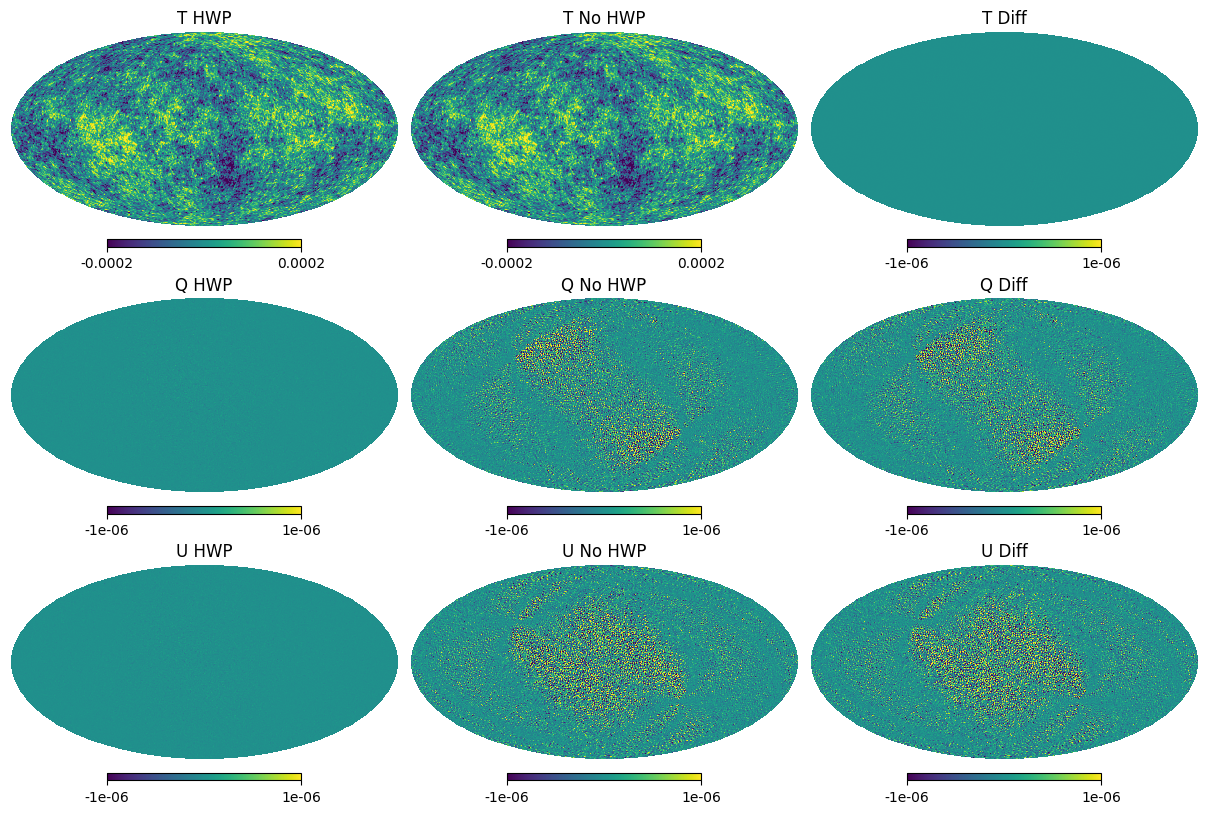

In [20]:
plt.figure(figsize=(12.0, 8.0))
hp.mollview(resultshwp.binned_map[0], sub=331, title="T HWP", min=-2e-4, max=2e-4)
hp.mollview(resultsnohwp.binned_map[0], sub=332, title="T No HWP", min=-2e-4, max=2e-4)
hp.mollview(
    resultshwp.binned_map[0] - resultsnohwp.binned_map[0],
    sub=333,
    title="T Diff",
    min=-1e-6,
    max=1e-6,
)
hp.mollview(resultshwp.binned_map[1], sub=334, title="Q HWP", min=-1e-6, max=1e-6)
hp.mollview(resultsnohwp.binned_map[1], sub=335, title="Q No HWP", min=-1e-6, max=1e-6)
hp.mollview(
    resultshwp.binned_map[1] - resultsnohwp.binned_map[1],
    sub=336,
    title="Q Diff",
    min=-1e-6,
    max=1e-6,
)
hp.mollview(resultshwp.binned_map[2], sub=337, title="U HWP", min=-1e-6, max=1e-6)
hp.mollview(resultsnohwp.binned_map[2], sub=338, title="U No HWP", min=-1e-6, max=1e-6)
hp.mollview(
    resultshwp.binned_map[2] - resultsnohwp.binned_map[2],
    sub=339,
    title="U Diff",
    min=-1e-6,
    max=1e-6,
)
# plt.savefig('Convolution.png')

In [21]:
clshwp = hp.anafast(resultshwp.binned_map)
clsnohwp = hp.anafast(resultsnohwp.binned_map)

In [23]:
lr0, BBr0 = np.loadtxt(
    "../../../../../miscellanea/data_spectra/inputs/fiducial_spectrum_planck18_r0p00_lensedtotCls.dat",
    usecols=(0, 3),
    unpack=True,
)
ll = lr0 * (lr0 + 1) / 2 / np.pi
BBr0 = BBr0 / ll

lr03, BBr03 = np.loadtxt(
    "../../../../../miscellanea/data_spectra/inputs/fiducial_spectrum_planck18_r0p03_lensedtotCls.dat",
    usecols=(0, 3),
    unpack=True,
)
ll = lr03 * (lr03 + 1) / 2 / np.pi
BBr03 = BBr03 / ll

Text(0.5, 0, 'Multipole - $\\ell$')

[2025-03-10 14:25:17,529 INFO MPI#0000] Substituting symbol C from STIXNonUnicode
[2025-03-10 14:25:17,595 INFO MPI#0000] Substituting symbol C from STIXNonUnicode


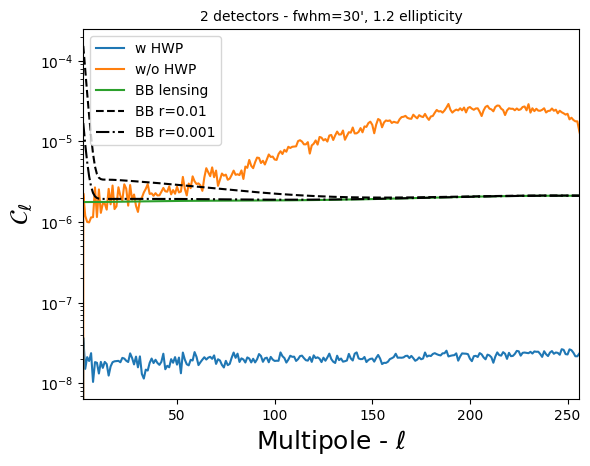

In [24]:
plt.plot(clshwp[2] * 1e12, label="w HWP")
plt.plot(clsnohwp[2] * 1e12, label="w/o HWP")
plt.plot(lr0, BBr0, label="BB lensing")
plt.plot(
    lr03, 0.01 * (BBr03 - BBr0) / 0.03 + BBr0, label="BB r=0.01", ls="--", color="k"
)
plt.plot(
    lr03, 0.001 * (BBr03 - BBr0) / 0.03 + BBr0, label="BB r=0.001", ls="-.", color="k"
)
plt.yscale("log")
plt.xlim(2, lmax)
plt.legend()
plt.title(
    "2 detectors - fwhm=30', 1.2 ellipticity",
    fontsize=10,
)

# plt.title("2 detectors - mismatch: 1' fwhm, 1% ellipticity, 5 deg rotated ellipses",
#          fontsize=10,
#         )
plt.ylabel(r"$\mathcal{C}_\ell$", fontsize=18)
plt.xlabel(r"Multipole - $\ell$", fontsize=18)
# plt.savefig('Leakage_spectra.png',bbox_inches='tight')